In [1]:
import requests
import shutil
import os
import io
import json
import time
import datetime
import dateutil
import random
import re
import ast
import pickle
import numpy as np
import pandas as pd
from IPython.display import clear_output
from pprint import pprint
import matplotlib.pyplot as plt

parent_folder='steam_data'

csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
csv_english_folder=os.path.join(parent_folder,"bulk","csv_english","early_access_standardized")
testing_folder=os.path.join(parent_folder,"bulk","testing")

In [2]:
with open(os.path.join(testing_folder,'still_in_early_access_FINAL'),'r') as file:
    current_ea_games=sorted(list(set([int(x) for x in file.read().split('\n')[:-1]])))
with open(os.path.join(testing_folder,'out_of_early_access_FINAL'),'r') as file:
    former_ea_games=sorted(list(set([int(x) for x in file.read().split('\n')[:-1]])))
full_games_list=sorted(list(set(current_ea_games+former_ea_games)))
with open(os.path.join(parent_folder,'official_appid_json_list'),'r') as file:
    temp_json=json.load(file)['applist']['apps']
official_app_list={}
for x in temp_json:
    official_app_list[x['appid']]=x['name']
print(len(full_games_list))
game_df=pd.read_csv(os.path.join(testing_folder,'20190124_games.csv'))
all_categories=set()
all_genres=set()
all_developers={}
all_publishers={}
for x in ['genres','developers','publishers','categories']:
    game_df[x]=game_df[x].apply(ast.literal_eval)
for i,row in game_df.iterrows():
    all_categories=all_categories | set(row['categories'])
    all_genres=all_genres | set(row['genres'])
    #print(all_genres)
    for developer in row['developers']:
        if developer not in all_developers:
            all_developers[developer]=1
        else:
            all_developers[developer]+=1
    for publisher in row['publishers']:
        if publisher not in all_publishers:
            all_publishers[publisher]=1
        else:
            all_publishers[publisher]+=1
#print(all_genres)
all_genres.remove('Early Access')
all_categories=sorted(list(all_categories))
all_genres=sorted(list(all_genres))

4935


In [3]:
num_reviews={}
early_access_start_time={}

In [5]:
csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
out_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_revised")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

for i,appid in enumerate(current_ea_games,1):
    temp_time_series=[]
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    df['num_reviews']=df['num_reviews'].apply(lambda x: max(1,x))
    df['num_games_owned']=df['num_games_owned'].apply(lambda x: max(1,x))
    num_reviews[int(appid)]=len(df)
    earliest_time=df['timestamp_updated'].min()
    early_access_start_time[int(appid)]=earliest_time
    latest_time=df['timestamp_updated'].max()
    num_months=int(np.ceil(float(latest_time-earliest_time+1)/(30.0*24.0*60.0*60.0)))
    for j in range(num_months):
        df_pos=df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                    (df['timestamp_updated']<earliest_time+(j+1)*30.0*24.0*60.0*60.0) &
                      (df['voted_up']==True)]
        df_neg=df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                    (df['timestamp_updated']<earliest_time+(j+1)*30.0*24.0*60.0*60.0) &
                      (df['voted_up']==False)]
        num_pos=float(len(df_pos))
        num_neg=float(len(df_neg))
        weight_likes_pos=num_pos+df_pos['votes_up'].sum()
        weight_likes_neg=num_neg+df_neg['votes_up'].sum()
        weight_games_pos=df_pos['num_games_owned'].sum()
        weight_games_neg=df_neg['num_games_owned'].sum()
        weight_reviews_pos=df_pos['num_reviews'].sum()
        weight_reviews_neg=df_neg['num_reviews'].sum()
        if num_neg>0 or num_pos>0:
            temp_time_series.append({'early_access':True,'month':j,'reviews':int(num_pos+num_neg),
                                     'ratio':num_pos/(num_neg+num_pos),'weight_likes_ratio':weight_likes_pos/(weight_likes_pos+weight_likes_neg),
                                    'weight_games_ratio':weight_games_pos/(weight_games_pos+weight_games_neg),
                                    'weight_reviews_ratio':weight_reviews_pos/(weight_reviews_pos+weight_reviews_neg)})
    pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series.csv'),index=False)
    clear_output(wait=True)
    print(str(i)+"/"+str(len(current_ea_games)))

2939/2939


In [6]:
csv_folder=os.path.join(parent_folder,"bulk","csv_no_text","early_access_standardized")
out_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_revised")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)


normal_review_start_time={}
for i,appid in enumerate(former_ea_games,1):
    df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_all.csv'))
    df['num_reviews']=df['num_reviews'].apply(lambda x: max(1,x))
    df['num_games_owned']=df['num_games_owned'].apply(lambda x: max(1,x))
    if len(df[df['written_during_early_access']==True])>0 and len(df[df['written_during_early_access']==False])>0:
        num_reviews[int(appid)]=len(df)
        earliest_time=df['timestamp_updated'].min()
        normal_review_time=df[df['written_during_early_access']==False]['timestamp_updated'].min()
        early_access_start_time[int(appid)]=earliest_time
        normal_review_start_time[int(appid)]=normal_review_time
        latest_time=df['timestamp_updated'].max()

        temp_time_series=[]
        num_months=int(np.ceil(float(normal_review_time-earliest_time)/(30.0*24.0*60.0*60.0)))
        for j in range(num_months):
            df_pos=df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<min(earliest_time+(j+1)*30.0*24.0*60.0*60.0,normal_review_time)) &
                          (df['voted_up']==True)]
            df_neg=df[(df['timestamp_updated']>=earliest_time+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<min(earliest_time+(j+1)*30.0*24.0*60.0*60.0,normal_review_time)) &
                          (df['voted_up']==False)]
            num_pos=float(len(df_pos))
            num_neg=float(len(df_neg))
            weight_likes_pos=num_pos+df_pos['votes_up'].sum()
            weight_likes_neg=num_neg+df_neg['votes_up'].sum()
            weight_games_pos=df_pos['num_games_owned'].sum()
            weight_games_neg=df_neg['num_games_owned'].sum()
            weight_reviews_pos=df_pos['num_reviews'].sum()
            weight_reviews_neg=df_neg['num_reviews'].sum()
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':True,'month':j,'reviews':int(num_pos+num_neg),
                                         'ratio':num_pos/(num_neg+num_pos),'weight_likes_ratio':weight_likes_pos/(weight_likes_pos+weight_likes_neg),
                                        'weight_games_ratio':weight_games_pos/(weight_games_pos+weight_games_neg),
                                        'weight_reviews_ratio':weight_reviews_pos/(weight_reviews_pos+weight_reviews_neg)})
        pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series_early.csv'),index=False)

        temp_time_series=[]
        num_months=int(np.ceil(float(latest_time-normal_review_time+1)/(30.0*24.0*60.0*60.0)))
        for j in range(num_months):
            df_pos=df[(df['timestamp_updated']>=normal_review_time+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<normal_review_time+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==True)]
            df_neg=df[(df['timestamp_updated']>=normal_review_time+(j)*30.0*24.0*60.0*60.0) &
                        (df['timestamp_updated']<normal_review_time+(j+1)*30.0*24.0*60.0*60.0) &
                          (df['voted_up']==False)]
            num_pos=float(len(df_pos))
            num_neg=float(len(df_neg))
            weight_likes_pos=num_pos+df_pos['votes_up'].sum()
            weight_likes_neg=num_neg+df_neg['votes_up'].sum()
            weight_games_pos=df_pos['num_games_owned'].sum()
            weight_games_neg=df_neg['num_games_owned'].sum()
            weight_reviews_pos=df_pos['num_reviews'].sum()
            weight_reviews_neg=df_neg['num_reviews'].sum()
            if num_neg>0 or num_pos>0:
                temp_time_series.append({'early_access':False,'month':j,'reviews':int(num_pos+num_neg),
                                         'ratio':num_pos/(num_neg+num_pos),'weight_likes_ratio':weight_likes_pos/(weight_likes_pos+weight_likes_neg),
                                        'weight_games_ratio':weight_games_pos/(weight_games_pos+weight_games_neg),
                                        'weight_reviews_ratio':weight_reviews_pos/(weight_reviews_pos+weight_reviews_neg)})
        pd.DataFrame(temp_time_series).to_csv(os.path.join(out_folder,str(appid)+'_month_time_series_release.csv'),index=False)



        clear_output(wait=True)
        print(str(i)+"/"+str(len(former_ea_games)))

1996/1996


In [128]:
game_df.head()

,appid,categories,content_warning,controller_support,developers,failed,genres,has_achievements,has_metacritic,is_free,...,multiple_packages,name,num_achievements,num_languages,num_movies,num_reviews,num_screenshots,platforms,publishers,still_in_early_access
0,15540,"[Single-player, Steam Achievements, Steam Trad...",False,False,"[Dejobaan Games, LLC]",NaN,"[Action, Early Access, Indie]",True,False,False,...,True,1... 2... 3... KICK IT! (Drop That Beat Like a...,1,1,1,483,10,1,"[Dejobaan Games, LLC]",True
1,16900,"[Single-player, Online Multi-Player, Online Co...",False,False,[BlackFoot Studios],NaN,"[Action, Indie, Early Access]",False,False,False,...,False,Ground Branch,0,1,2,591,16,1,[BlackFoot Studios],True
2,25000,"[Single-player, Partial Controller Support, In...",False,False,[Wolfire Games],NaN,"[Action, Indie]",False,False,False,...,False,Overgrowth,0,1,3,4428,9,3,[Wolfire Games],False
3,108600,"[Single-player, Multi-player, Co-op, Shared/Sp...",False,False,[The Indie Stone],NaN,"[Indie, RPG, Simulation, Early Access]",False,False,False,...,True,Project Zomboid,0,16,1,19407,12,3,[The Indie Stone],True
4,116100,"[Single-player, Multi-player, Shared/Split Scr...",False,False,[Eclipse Games],NaN,"[Indie, Racing]",True,False,False,...,False,Super Toy Cars,26,2,1,327,20,2,[Eclipse Games],False


In [44]:
relevant_appids=[]

for i,appid in enumerate(former_ea_games,1):
    if appid in num_reviews:
        relevant_appids.append(appid)

relevant_appids=np.array(relevant_appids)
        
#temp=int(len(training_appids)/10)
#validation_appids = [training_appids.pop(random.randrange(len(training_appids))) for x in range(temp)]
#testing_appids = [training_appids.pop(random.randrange(len(training_appids))) for x in range(temp)]

In [70]:
from sklearn.model_selection import train_test_split

ts_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_revised")

def make_vector(appid,df):
    num_months=int((normal_review_start_time[appid]-early_access_start_time[appid])/(30.0*24.0*60.0*60.0))
    chosen_month=random.randint(0,num_months)
    first_one_hot_encoding=16
    v=np.zeros((1,first_one_hot_encoding+len(all_categories)+len(all_genres)+2))

    found_row=False
    for i,row in df.iterrows():
        if row['month']==chosen_month:
            found_row=True
            month_index=i
            break
        elif row['month']>chosen_month:
            found_row=True
            month_index=max(0,i-1)
            break
    if not found_row:
        month_index=len(df)-1
    
    df['pos_reviews']=df['reviews']*df['ratio']
    df['pos_weight_games_reviews']=df['reviews']*df['weight_games_ratio']
    df['pos_weight_likes_reviews']=df['reviews']*df['weight_likes_ratio']
    df['pos_weight_reviews_reviews']=df['reviews']*df['weight_reviews_ratio']
    v[0,0]=chosen_month
    v[0,1]=df.iloc[month_index]['reviews']
    v[0,2]=df.iloc[month_index]['pos_reviews']
    v[0,3]=df.iloc[month_index]['pos_weight_games_reviews']
    v[0,4]=df.iloc[month_index]['pos_weight_likes_reviews']
    v[0,5]=df.iloc[month_index]['pos_weight_reviews_reviews']
    v[0,6]=df.iloc[0:month_index+1]['reviews'].sum()
    v[0,7]=df.iloc[0:month_index+1]['pos_reviews'].sum()
    v[0,8]=df.iloc[0:month_index+1]['pos_weight_games_reviews'].sum()
    v[0,9]=df.iloc[0:month_index+1]['pos_weight_likes_reviews'].sum()
    v[0,10]=df.iloc[0:month_index+1]['pos_weight_reviews_reviews'].sum()
    v[0,11]=df.iloc[0]['reviews']
    v[0,12]=df.iloc[0]['pos_reviews']
    v[0,13]=df.iloc[0]['pos_weight_games_reviews']
    v[0,14]=df.iloc[0]['pos_weight_likes_reviews']
    v[0,15]=df.iloc[0]['pos_weight_reviews_reviews']
    categories=game_df[game_df['appid']==appid]['categories'].iloc[0]
    genres=game_df[game_df['appid']==appid]['genres'].iloc[0]
    developers=game_df[game_df['appid']==appid]['developers'].iloc[0]
    publishers=game_df[game_df['appid']==appid]['publishers'].iloc[0]
    for category in categories:
        if category != 'Early Access':
            v[0,first_one_hot_encoding+all_categories.index(category)]=1
    for genre in genres:
        if genre != 'Early Access':
            v[0,first_one_hot_encoding+len(all_categories)+all_genres.index(genre)]=1
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)]=max([all_developers[x] for x in developers])
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)+1]=max([all_publishers[x] for x in publishers])
    return v

def make_labeled_vector(appid,df_early,df_release):
    return make_vector(appid,df_early),[df_release.iloc[0]['ratio']*1],num_reviews[int(appid)]

vecs=[]
labels=[]
weights=[]
bl=[]
for i,appid in enumerate(relevant_appids,1):
    print(appid)
    df_early=pd.read_csv(os.path.join(ts_folder,str(appid)+'_month_time_series_early.csv'))
    df_release=pd.read_csv(os.path.join(ts_folder,str(appid)+'_month_time_series_release.csv'))
    for j in range(1):
        v,l,w=make_labeled_vector(appid,df_early,df_release)
        vecs.append(v)
        labels.append(l)
        weights.append(1)#np.log(w+1.0))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(relevant_appids)))
    
vecs=np.vstack(vecs)
labels=np.vstack(labels)[:,0]
weights=np.vstack(weights)[:,0]

from sklearn.model_selection import train_test_split

training_idxs,testval_idxs=train_test_split(np.array(list(range(len(relevant_appids)))), test_size=0.2)
testing_idxs,validation_idxs=train_test_split(testval_idxs, test_size=0.5)

training_ids=relevant_appids[training_idxs]
validation_ids=relevant_appids[validation_idxs]
testing_ids=relevant_appids[testing_idxs]

training_vecs=vecs[training_idxs,:]
validation_vecs=vecs[validation_idxs,:]
testing_vecs=vecs[testing_idxs,:]

training_labels=labels[training_idxs]
validation_labels=labels[validation_idxs]
testing_labels=labels[testing_idxs]
                           

training_w=weights[training_idxs]
validation_w=weights[validation_idxs]
testing_w=weights[testing_idxs]
#training_vecs=vecs[training_ids,:]

#testing_vecs, validation_vecs, testing_labels, validation_labels,testing_w, validation_w = train_test_split(testval_vecs, testval_labels, testval_w, test_size=0.5)
    
                                           
print(len(training_vecs))                
print(len(testing_vecs))                
print(len(validation_vecs))

1930/1930
1544
193
193


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


regressor=RandomForestRegressor(n_estimators=128,n_jobs=-1)#,min_samples_split=8,max_features="log2")

regressor.fit(training_vecs,training_labels,sample_weight=training_w);
linreg=LinearRegression().fit(np.transpose([training_vecs[:,1]/training_vecs[:,0]]), training_labels,sample_weight=training_w)
linreg_all=LinearRegression().fit(training_vecs,training_labels,sample_weight=training_w)

print("Validation MSEs:")
predicted_labels = regressor.predict(validation_vecs)
validation_bl = linreg.predict(np.transpose([validation_vecs[:,1]/validation_vecs[:,0]]))
validation_bl_all = linreg_all.predict(validation_vecs)
print(mean_squared_error(predicted_labels,validation_labels,sample_weight=validation_w))
print(mean_squared_error(validation_bl,validation_labels,sample_weight=validation_w))
print(mean_squared_error((predicted_labels+validation_bl)/2.0,validation_labels,sample_weight=validation_w))
print(mean_squared_error(validation_bl_all,validation_labels,sample_weight=validation_w))
print(mean_squared_error((predicted_labels+validation_bl_all)/2.0,validation_labels,sample_weight=validation_w))

print("\nTesting MSEs:")
predicted_labels = regressor.predict(testing_vecs)
testing_bl = linreg.predict(np.transpose([testing_vecs[:,1]/testing_vecs[:,0]]))
testing_bl_all = linreg_all.predict(testing_vecs)
print(mean_squared_error(predicted_labels,testing_labels,sample_weight=testing_w))
print(mean_squared_error(testing_bl,testing_labels,sample_weight=testing_w))
print(mean_squared_error((predicted_labels+testing_bl)/2,testing_labels,sample_weight=testing_w))
print(mean_squared_error(testing_bl_all,testing_labels,sample_weight=testing_w))
print(mean_squared_error((predicted_labels+testing_bl_all)/2,testing_labels,sample_weight=testing_w))


Validation MSEs:
0.07120988303042802
0.06059960832705281
0.06219488779827322
0.6693528825646538
0.22119941091623516

Testing MSEs:
0.05414958116668083
0.05921214940288707
0.05398776239699477
0.06572024440114824
0.05559716431539449


In [89]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [128],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,8,16],
            "bootstrap": [True, False],
            "n_jobs" : [-1],
            "random_state": [8]
            }


grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

grid.fit(training_vecs,training_labels)

print(grid.best_score_ , grid.best_params_)

0

14.29983862323145
21.188512076992616
14.741756606510375
15.969131841615786
21.216458154318076
15.996382876923798


In [257]:
ts_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_revised")

def make_vector(appid,df,chosen_month):
    #num_months=int((normal_review_start_time[appid]-early_access_start_time[appid])/(30.0*24.0*60.0*60.0))
    v=np.zeros((1,68))
    first_one_hot_encoding=11
    
    found_row=False
    for i,row in df.iterrows():
        if row['month']==chosen_month:
            found_row=True
            month_index=i
            break
        elif row['month']>chosen_month:
            found_row=True
            month_index=max(0,i-1)
            break
    if not found_row:
        month_index=len(df)-1
    
    v[0,0]=chosen_month
    v[0,1]=float(df.iloc[month_index]['reviews'])/float(df.iloc[0]['reviews'])
    v[0,2]=df.iloc[month_index]['ratio']
    v[0,3]=df.iloc[month_index]['weight_games_ratio']
    v[0,4]=df.iloc[month_index]['weight_likes_ratio']
    v[0,5]=df.iloc[month_index]['weight_reviews_ratio']
    v[0,6]=df.iloc[0]['reviews']
    v[0,7]=df.iloc[0]['ratio']
    v[0,8]=df.iloc[0]['weight_games_ratio']
    v[0,9]=df.iloc[0]['weight_likes_ratio']
    v[0,10]=df.iloc[0]['weight_reviews_ratio']
    categories=game_df[game_df['appid']==appid]['categories'].iloc[0]
    genres=game_df[game_df['appid']==appid]['genres'].iloc[0]
    developers=game_df[game_df['appid']==appid]['developers'].iloc[0]
    publishers=game_df[game_df['appid']==appid]['publishers'].iloc[0]
    for category in categories:
        if category != 'Early Access':
            v[0,first_one_hot_encoding+all_categories.index(category)]=1
    for genre in genres:
        if genre != 'Early Access':
            v[0,first_one_hot_encoding+len(all_categories)+all_genres.index(genre)]=1
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)]=max([all_developers[x] for x in developers])
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)+1]=max([all_publishers[x] for x in publishers])
    return v

def make_labeled_vector(appid,df_early,df_release):
    return make_vector(appid,df_early),[df_release.iloc[0]['ratio']]

vecs=[]
for i,appid in enumerate(current_ea_games,1):
    df=pd.read_csv(os.path.join(ts_folder,str(appid)+'_month_time_series.csv'))
    vecs.append(make_vector(appid,df,1))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(current_ea_games))+": "+str(regressor.predict(vecs[-1])))

2939/2939: [0.83268837]


In [261]:
vec_out_folder=os.path.join(parent_folder,"bulk","testing","20190124_ea_vecs")
if not os.path.exists(vec_out_folder):
    os.makedirs(vec_out_folder)

for i,v in enumerate(vecs,0):
    with open(os.path.join(vec_out_folder,str(current_ea_games[i])),'wb') as file:
        pickle.dump(vecs[i],file)
    clear_output(wait=True)
    print(str(i+1)+"/"+str(len(current_ea_games)))

2939/2939


In [262]:
tempvar=0
for i,appid in enumerate(former_ea_games,1):
    if appid in num_reviews:
        tempvar+=1
print(tempvar)
print(len(current_ea_games))

1930
2939


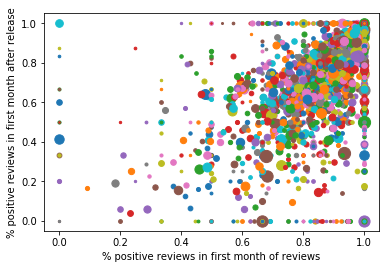

In [16]:
%matplotlib inline

x_vals=[training_vecs[i,1]/training_vecs[i,0] for i in range(len(training_vecs))]
y_vals=[training_labels[i] for i in range(len(training_labels))]
size_vals=[np.log(num_reviews_df.loc[appid]['num_reviews']+1.5) for appid in training_ids]
for i in range(len(testing_vecs)):
    x_vals.append(testing_vecs[i,1]/testing_vecs[i,0])
    y_vals.append(testing_labels[i])
    size_vals.append(np.log(num_reviews_df.loc[validation_ids[i]]['num_reviews']+1.5))
for i in range(len(validation_vecs)):
    x_vals.append(validation_vecs[i,1]/validation_vecs[i,0])
    y_vals.append(validation_labels[i])
    size_vals.append(np.log(num_reviews_df.loc[validation_ids[i]]['num_reviews']+1.5))
    
    
#print(x_vals)

#or appid in useful_examples:
#   x.append(useful_examples[appid]['original_ratio'])
#   y.append(useful_examples[appid]['ratio_soon_after_positive'])
#   size.append(np.log(useful_examples[appid]['num_reviews_soon_after_early_access']+1.5))
for i in range(len(x_vals)):
    plt.plot(x_vals[i],y_vals[i],'o',ms=size_vals[i])
plt.xlabel("% positive reviews in first month of reviews")
plt.ylabel("% positive reviews in first month after release")
plt.show()


In [293]:
plt.rcParams['figure.figsize']=[6.0,4.0] #DEFAULT
#plt.rcParams['figure.figsize']=[12.0,8.0]

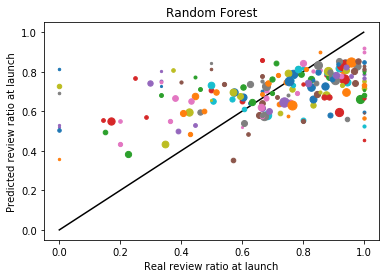

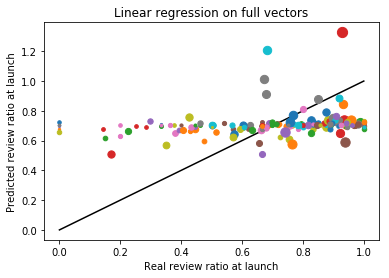

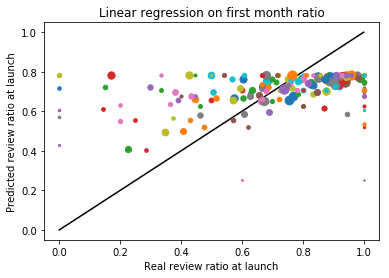

In [17]:
#plt.rcParams['figure.figsize']=[12.0,8.0]
x_vals=testing_labels
y_vals=predicted_labels
size_vals=[np.log(num_reviews_df.loc[int(appid)]['num_reviews']+1.5) for appid in testing_ids]
#plt.rcParams['figure.figsize']=[12.0,8.0]
plt.plot([0,1],[0,1],'-',c='k')
for i in range(len(x_vals)):
    plt.plot(x_vals[i],y_vals[i],'o',ms=size_vals[i])
plt.xlabel("Real review ratio at launch")
plt.ylabel("Predicted review ratio at launch")
plt.title("Random Forest")
plt.show()

x_vals=testing_labels
y_vals=testing_bl_all
size_vals=[np.log(num_reviews_df.loc[int(appid)]['num_reviews']+1.5) for appid in testing_ids]
#plt.rcParams['figure.figsize']=[12.0,8.0]
plt.plot([0,1],[0,1],'-',c='k')
for i in range(len(x_vals)):
    plt.plot(x_vals[i],y_vals[i],'o',ms=size_vals[i])
plt.xlabel("Real review ratio at launch")
plt.ylabel("Predicted review ratio at launch")
plt.title("Linear regression on full vectors")
plt.show()

x_vals=testing_labels
y_vals=testing_bl
size_vals=[np.log(num_reviews_df.loc[int(appid)]['num_reviews']+1.5) for appid in testing_ids]
#plt.rcParams['figure.figsize']=[12.0,8.0]
plt.plot([0,1],[0,1],'-',c='k')
for i in range(len(x_vals)):
    plt.plot(x_vals[i],y_vals[i],'o',ms=size_vals[i])
plt.xlabel("Real review ratio at launch")
plt.ylabel("Predicted review ratio at launch")
plt.title("Linear regression on first month ratio")
plt.show()
'''
x_vals=np.transpose([testing_vecs[:,1]/testing_vecs[:,0]])
y_vals=testing_bl
size_vals=[np.log(num_reviews_df.loc[int(appid)]['num_reviews']+1.5) for appid in testing_ids]
#plt.rcParams['figure.figsize']=[12.0,8.0]
plt.plot([0,1],[0,1],'-',c='k')
for i in range(len(x_vals)):
    plt.plot(x_vals[i],y_vals[i],'o',ms=size_vals[i])
plt.xlabel("First month review ratio")
plt.ylabel("Predicted review ratio at launch")
plt.title("Linear regression on first month ratio")
plt.show()''';

In [296]:
print(len(all_categories)+len(all_genres))

55


5274019


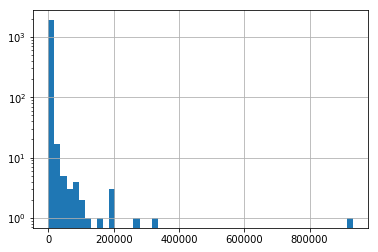

In [308]:
num_reviews_list=[]
for i,appid in enumerate(former_ea_games,1):
    if appid in num_reviews:
        num_reviews_list.append(num_reviews[appid])
        
series=pd.Series(num_reviews_list)
print(series.sum())
series.hist(log=True,bins=50)

1996/1996


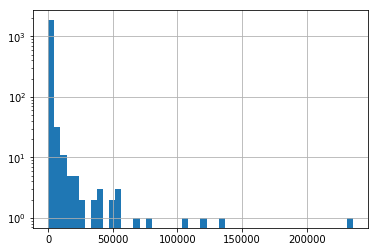

In [311]:
csv_folder=os.path.join(parent_folder,"bulk","csv_english","early_access_standardized")
num_reviews_list=[]
for i,appid in enumerate(former_ea_games,1):
    if appid in num_reviews:
        try:
            df=pd.read_csv(os.path.join(csv_folder,str(appid)+'_reviews_english.csv'))
            num_reviews_list.append(len(df))
        except:
            pass
    clear_output(wait=True)
    print(str(i)+"/"+str(len(former_ea_games)))
        


2366775


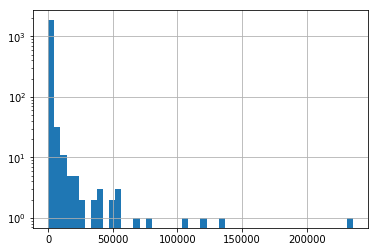

In [312]:
series=pd.Series(num_reviews_list)
print(series.sum())
series.hist(log=True,bins=50)

In [126]:
early_access_start_time_df=pd.DataFrame.from_dict(early_access_start_time,orient='index',columns=['time'])
normal_review_start_time_df=pd.DataFrame.from_dict(normal_review_start_time,orient='index',columns=['time'])
num_reviews_df=pd.DataFrame.from_dict(num_reviews,orient='index',columns=['num_reviews'])
early_access_start_time_df=early_access_start_time_df.reset_index().rename(index=str,columns={'index':'appid'})
normal_review_start_time_df=normal_review_start_time_df.reset_index().rename(index=str,columns={'index':'appid'})
num_reviews_df=num_reviews_df.reset_index().rename(index=str,columns={'index':'appid'})
early_access_start_time_df.to_csv(os.path.join(testing_folder,'20190126_early_access_start_time.csv'),index=False)
normal_review_start_time_df.to_csv(os.path.join(testing_folder,'20190126_normal_review_start_time.csv'),index=False)
#for i,row in df.iterrows():
#    if row['month']==chosen_month:
#        found_row=True
#        month_index=i
#        break
#    elif row['month']>chosen_month:
#        found_row=True
#        month_index=max(0,i-1)
#        break

num_reviews_df.to_csv(os.path.join(testing_folder,'20190126_num_reviews.csv'),index=False)


In [130]:
num_reviews_df=pd.read_csv(os.path.join(testing_folder,'20190126_num_reviews.csv'))
num_reviews_df.head()

,appid,num_reviews
0,15540,483
1,16900,591
2,108600,19407
3,217120,64
4,223490,829


In [4]:
num_reviews_df=pd.read_csv(os.path.join(testing_folder,'20190126_num_reviews.csv')).set_index('appid')
early_access_start_time_df=pd.read_csv(os.path.join(testing_folder,'20190126_early_access_start_time.csv')).set_index('appid')
normal_review_start_time_df=pd.read_csv(os.path.join(testing_folder,'20190126_normal_review_start_time.csv')).set_index('appid')
num_english_reviews={}

In [14]:
from sklearn.model_selection import train_test_split

word_freq_folder=os.path.join(parent_folder,"bulk","csv_english","former_early_access_text_cleaned_count_vecs")


english_appids=np.array(sorted([int(x.split('_')[0]) for x in os.listdir(word_freq_folder) if x.split('_')[0]!='all']))

                
ts_folder=os.path.join(parent_folder,"bulk","csv_no_text","time_series_by_month_revised")

def make_vector(appid,df):
    num_months=int((normal_review_start_time_df.loc[int(appid)]['time']-early_access_start_time_df.loc[int(appid)]['time'])/(30.0*24.0*60.0*60.0))
    chosen_month=random.randint(0,num_months)
    
    first_one_hot_encoding=16
    
    wfv = np.genfromtxt(os.path.join(word_freq_folder,str(appid)+'_count_vec.csv'), delimiter=',')
    v=np.zeros((1,first_one_hot_encoding+len(all_categories)+len(all_genres)+2+len(wfv)))

    found_row=False
    for i,row in df.iterrows():
        if row['month']==chosen_month:
            found_row=True
            month_index=i
            break
        elif row['month']>chosen_month:
            found_row=True
            month_index=max(0,i-1)
            break
    if not found_row:
        month_index=len(df)-1
        
    found_row=False
    for i,row in df.iterrows():
        if row['month']>=3:
            found_row=True
            early_month_3_idx=i
            break
    if not found_row:
        early_month_3_idx=1
    
    df['pos_reviews']=df['reviews']*df['ratio']
    df['pos_weight_games_reviews']=df['reviews']*df['weight_games_ratio']
    df['pos_weight_likes_reviews']=df['reviews']*df['weight_likes_ratio']
    df['pos_weight_reviews_reviews']=df['reviews']*df['weight_reviews_ratio']
    v[0,0]=chosen_month
    v[0,1]=df.iloc[month_index]['reviews']
    v[0,2]=df.iloc[month_index]['pos_reviews']
    v[0,3]=df.iloc[month_index]['pos_weight_games_reviews']
    v[0,4]=df.iloc[month_index]['pos_weight_likes_reviews']
    v[0,5]=df.iloc[month_index]['pos_weight_reviews_reviews']
    v[0,6]=df.iloc[0:month_index+1]['reviews'].sum()
    v[0,7]=df.iloc[0:month_index+1]['pos_reviews'].sum()
    v[0,8]=df.iloc[0:month_index+1]['pos_weight_games_reviews'].sum()
    v[0,9]=df.iloc[0:month_index+1]['pos_weight_likes_reviews'].sum()
    v[0,10]=df.iloc[0:month_index+1]['pos_weight_reviews_reviews'].sum()
    v[0,11]=df.iloc[0:early_month_3_idx]['reviews'].sum()
    v[0,12]=df.iloc[0:early_month_3_idx]['pos_reviews'].sum()
    v[0,13]=df.iloc[0:early_month_3_idx]['pos_weight_games_reviews'].sum()
    v[0,14]=df.iloc[0:early_month_3_idx]['pos_weight_likes_reviews'].sum()
    v[0,15]=df.iloc[0:early_month_3_idx]['pos_weight_reviews_reviews'].sum()
    categories=game_df[game_df['appid']==appid]['categories'].iloc[0]
    genres=game_df[game_df['appid']==appid]['genres'].iloc[0]
    developers=game_df[game_df['appid']==appid]['developers'].iloc[0]
    publishers=game_df[game_df['appid']==appid]['publishers'].iloc[0]
    for category in categories:
        if category != 'Early Access':
            v[0,first_one_hot_encoding+all_categories.index(category)]=1
    for genre in genres:
        if genre != 'Early Access':
            v[0,first_one_hot_encoding+len(all_categories)+all_genres.index(genre)]=1
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)]=max([all_developers[x] for x in developers])
    v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)+1]=max([all_publishers[x] for x in publishers])
    for i,x in enumerate(wfv,0):
        v[0,first_one_hot_encoding+len(all_categories)+len(all_genres)+2+i]=x
    return v

def make_labeled_vector(appid,df_early,df_release):
    found_row=False
    for i,row in df_release.iterrows():
        if row['month']>=3:
            found_row=True
            release_month_3_idx=i
            break
    if not found_row:
        release_month_3_idx=1
    df_release['pos_reviews']=df_release['reviews']*df_release['ratio']
    found_row=False
    for i,row in df_early.iterrows():
        if row['month']>=3:
            found_row=True
            early_month_3_idx=i
            break
    if not found_row:
        early_month_3_idx=1
    df_early['pos_reviews']=df_early['reviews']*df_early['ratio']
    
    v=make_vector(appid,df_early)
    
    rel_ratio=df_release.iloc[0:release_month_3_idx]['pos_reviews'].sum()/ \
                                       float(df_release.iloc[0:release_month_3_idx]['reviews'].sum())
    
    early_ratio=df_early.iloc[0:early_month_3_idx]['pos_reviews'].sum()/ \
                                       float(df_early.iloc[0:early_month_3_idx]['reviews'].sum())
    #return v,[rel_ratio-early_ratio],df_early['reviews'].sum()
    
    #if early_ratio!=0:
    return v,[rel_ratio],df_early['reviews'].sum()
    
    #else:
    #    return v,[1.5],df_early['reviews'].sum()

vecs=[]
labels=[]
weights=[]
bl=[]
for i,appid in enumerate(english_appids,1):
    print(appid)
    df_early=pd.read_csv(os.path.join(ts_folder,str(appid)+'_month_time_series_early.csv'))
    df_release=pd.read_csv(os.path.join(ts_folder,str(appid)+'_month_time_series_release.csv'))
    for j in range(1):
        v,l,w=make_labeled_vector(appid,df_early,df_release)
        vecs.append(v)
        labels.append(l)
        weights.append(1)#np.log(w+1.0))
    clear_output(wait=True)
    print(str(i)+"/"+str(len(english_appids)))
    
vecs=np.vstack(vecs)
labels=np.vstack(labels)[:,0]
weights=np.vstack(weights)[:,0]

print("z "+str(len(v[0,:])))
slicer=[not (16<=x<16+len(all_categories)+len(all_genres)) for x in range(len(v[0,:]))]
vecs=vecs[:,slicer]
print("z "+str(len(v[0,:])))
vecs=vecs[:,11:]
print("z "+str(len(v[0,:])))
from sklearn.model_selection import train_test_split

training_idxs,testval_idxs=train_test_split(np.array(list(range(len(english_appids)))), test_size=0.2)
testing_idxs,validation_idxs=train_test_split(testval_idxs, test_size=0.5)

training_ids=english_appids[training_idxs]
validation_ids=english_appids[validation_idxs]
testing_ids=english_appids[testing_idxs]

training_vecs=vecs[training_idxs,:]
validation_vecs=vecs[validation_idxs,:]
testing_vecs=vecs[testing_idxs,:]

training_labels=labels[training_idxs]
validation_labels=labels[validation_idxs]
testing_labels=labels[testing_idxs]
                           

training_w=weights[training_idxs]
validation_w=weights[validation_idxs]
testing_w=weights[testing_idxs]
#training_vecs=vecs[training_ids,:]

#testing_vecs, validation_vecs, testing_labels, validation_labels,testing_w, validation_w = train_test_split(testval_vecs, testval_labels, testval_w, test_size=0.5)
    
                                           
print(len(training_vecs))                
print(len(testing_vecs))                
print(len(validation_vecs))

1930/1930
z 145
z 145
z 145
1544
193
193


In [71]:
print(len(vecs[0,:]))

79


In [98]:
print("testing")
a=input()
clear_output(wait=True)
print(a)

123123
